In [1]:
# Cell 1 - Setup, imports, scelta esperimento

augmentation = True

import os
import sys

sys.path.insert(0, os.path.join(os.getcwd(), 'local_lib'))

import torch
from sklearn.metrics import classification_report

try:
    import google.colab  # type: ignore
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive  # type: ignore
    drive.mount("/content/drive")
    PROJECT_ROOT = "/content/drive/MyDrive/[2025-2026] AN2DL/challenge2"
else:
    PROJECT_ROOT = os.getcwd()

os.chdir(PROJECT_ROOT)
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

print("Project root:", PROJECT_ROOT)
print("Working dir:", os.getcwd())

from includes.config import TrainingConfig, GRID_SEARCH_SPACES
from includes.data_utils import (
    load_labels_and_split,
    load_full_labels,
    get_transforms,
    create_dataloaders,
)

from includes.model_utils import (
    build_model,
    create_criterion_optimizer_scheduler,
    train_model,
    evaluate,
)
from includes.inference_utils import create_test_loader, run_inference_and_save

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("Torch version:", torch.__version__)

# --------- choose which experiment to run ---------
# available:
#   "baseline"
#   "resnet50_big"
#   "resnet50_big_masks"
#   "challenge_2-2"
EXP_NAME = "aug_mask_test"
cfg = EXPERIMENTS[EXP_NAME]

# base cfg con default (paths, val_size, ecc.)
cfg = TrainingConfig(exp_name=EXP_NAME)
cfg.project_root = PROJECT_ROOT
cfg.out_dir = "out"

# griglia associata a questo esperimento
param_grid = GRID_SEARCH_SPACES[EXP_NAME]
param_grid


Project root: c:\Users\danie\ANN
Working dir: c:\Users\danie\ANN
Python path contains 'includes'? -> True
Using device: cpu
Torch version: 2.9.1+cpu
Using device: cpu
Torch version: 2.9.1+cpu


TrainingConfig(exp_name='aug_resnet50_crop', project_root='c:\\Users\\danie\\ANN', data_dir='data', out_dir='out', train_img_dir='train_data', test_img_dir='test_data', labels_csv='train_labels.csv', mask_dir=None, backbone='resnet50', img_size=224, batch_size=16, num_workers=4, val_size=0.15, random_seed=101, mask_mode='crop_bbox', lr=0.0001, weight_decay=0.0001, epochs=40, use_scheduler=True, use_masks=True)

In [2]:
# Cell 2 - Grid search with optional StratifiedKFold

import itertools
import copy
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import StratifiedKFold

base_cfg = cfg  # base config for this experiment

keys = list(param_grid.keys())
values_list = [param_grid[k] for k in keys]
combos = list(itertools.product(*values_list))
n_combos = len(combos)

print("==============================================================")
print(f"GRID SEARCH for experiment '{EXP_NAME}' with {n_combos} combinations")
print("Param keys:", keys)
print("==============================================================")

results = []
best_val_f1 = -1.0
best_cfg = None
best_state_dict = None
best_idx_to_label = None
best_val_t = None

for i, values in enumerate(combos, start=1):
    params = dict(zip(keys, values))

    print("\n--------------------------------------------------------------")
    print(f"[Grid {i}/{n_combos}] params = {params}")

    # Validation strategy from params (fallback to holdout)
    cv_type = params.get("cv_type", "holdout")
    n_splits = int(params.get("n_splits", 5))

    # 1) Copy base cfg and attach all params as attributes
    cfg_i = copy.deepcopy(base_cfg)
    for k, v in params.items():
        setattr(cfg_i, k, v)

    # 2) Common: full labels + transforms
    labels_df, unique_labels, label_to_idx, idx_to_label_i = load_full_labels(cfg_i)
    train_t_i, val_t_i = get_transforms(cfg_i)
    num_classes = len(unique_labels)

    fold_f1s = []
    best_state_i = None

    if cv_type == "kfold":
        # ----- Stratified K-Fold -----
        print(f"  >> Using StratifiedKFold with {n_splits} folds")

        skf = StratifiedKFold(
            n_splits=n_splits,
            shuffle=True,
            random_state=cfg_i.random_seed,
        )

        best_fold_f1 = -1.0

        for fold, (train_idx, val_idx) in enumerate(
            skf.split(labels_df, labels_df["label_idx"]), start=1
        ):
            print(f"    [Fold {fold}/{n_splits}]")

            train_df = labels_df.iloc[train_idx].reset_index(drop=True)
            val_df = labels_df.iloc[val_idx].reset_index(drop=True)

            train_loader_i, val_loader_i = create_dataloaders(
                cfg_i, train_df, val_df, train_t_i, val_t_i
            )

            model_i = build_model(cfg_i, num_classes=num_classes, device=device)
            criterion_i, optimizer_i, scheduler_i = create_criterion_optimizer_scheduler(
                cfg_i, model_i, train_df, device
            )

            best_state_fold, history_fold = train_model(
                cfg_i,
                model_i,
                train_loader_i,
                val_loader_i,
                criterion_i,
                optimizer_i,
                scheduler_i,
                device,
            )

            val_f1_list = history_fold.get("val_f1", history_fold.get("val_acc", []))
            fold_best_f1 = max(val_f1_list) if val_f1_list else 0.0
            fold_f1s.append(fold_best_f1)
            print(f"    >> Fold best F1: {fold_best_f1:.4f}")

            if fold_best_f1 > best_fold_f1:
                best_fold_f1 = fold_best_f1
                best_state_i = copy.deepcopy(best_state_fold)

            del model_i
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        run_best_f1 = float(np.mean(fold_f1s))
        print(f"  >> Mean F1 over {n_splits} folds: {run_best_f1:.4f}")

    else:
        # ----- Standard hold-out validation (current behaviour) -----
        train_df, val_df, unique_labels, label_to_idx, idx_to_label_i = load_labels_and_split(
            cfg_i
        )
        train_t_i, val_t_i = get_transforms(cfg_i)
        train_loader_i, val_loader_i = create_dataloaders(
            cfg_i, train_df, val_df, train_t_i, val_t_i
        )

        model_i = build_model(cfg_i, num_classes=num_classes, device=device)
        criterion_i, optimizer_i, scheduler_i = create_criterion_optimizer_scheduler(
            cfg_i, model_i, train_df, device
        )

        best_state_i, history_i = train_model(
            cfg_i,
            model_i,
            train_loader_i,
            val_loader_i,
            criterion_i,
            optimizer_i,
            scheduler_i,
            device,
        )

        val_f1_list = history_i.get("val_f1", history_i.get("val_acc", []))
        run_best_f1 = max(val_f1_list) if val_f1_list else 0.0
        print(f"Best val F1 for this run: {run_best_f1:.4f}")

        del model_i
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # 3) Save result row
    row = {"run": i, "best_val_f1": run_best_f1}
    for k in keys:
        row[k] = params[k]
    results.append(row)

    # 4) Update global best
    if run_best_f1 > best_val_f1:
        best_val_f1 = run_best_f1
        best_cfg = copy.deepcopy(cfg_i)
        best_state_dict = copy.deepcopy(best_state_i)
        best_idx_to_label = idx_to_label_i
        best_val_t = val_t_i

# ---------- grid search summary ----------
results_df = pd.DataFrame(results).sort_values("best_val_f1", ascending=False)
print("\n================ GRID SEARCH SUMMARY ================")
print(results_df)

print("\nBest config (from grid):")
print(best_cfg.__dict__)
print("Best val F1:", best_val_f1)

# ---------- objects for the rest of the notebook ----------
cfg = best_cfg
idx_to_label = best_idx_to_label
val_t = best_val_t

num_classes = len(idx_to_label)
model = build_model(cfg, num_classes=num_classes, device=device)
model.load_state_dict(best_state_dict)


In [3]:
# Cell 3 - Model, criterion, optimizer, scheduler

model = build_model(cfg, num_classes=len(unique_labels), device=device)
criterion, optimizer, scheduler = create_criterion_optimizer_scheduler(
    cfg, model, train_df, device
)


In [4]:
# Cell 4 - Training
if not augmentation:
    best_state, history = train_model(
        cfg, model, train_loader, val_loader, criterion, optimizer, scheduler, device
    )
    model.load_state_dict(best_state)

    # Final report on validation
    val_loss, val_acc, y_true, y_pred = evaluate(model, val_loader, criterion, device)
    print("Val acc:", val_acc)
    print(classification_report(y_true, y_pred, target_names=unique_labels))


In [5]:
# Cell 5 - Inference and submission
if not augmentation:
    test_loader, test_files = create_test_loader(cfg, val_t)
    run_inference_and_save(cfg, model, test_loader, idx_to_label, device)

In [6]:
if augmentation:
    # Optional: Run augmented training experiment
    # Imports for augmentation pipeline
    from includes.augmentation_pipeline import run_augmented_experiment

    # Configure augmentation parameters (adjusted for better performance)
    AUG_PARAMS = {
        # Geometric augmentations
        "flip_p": 0.5,                    # Horizontal flip probability
        "vertical_flip_p": 0.3,           # Vertical flip probability (NEW)
        "rotation_degrees": 15,           # Increased from 10 for more diversity
        
        # Zoom augmentation (RandomResizedCrop)
        "use_random_zoom": True,          # Enable random zoom/crop
        "zoom_scale_range": (0.8, 1.0),   # More aggressive zoom (80-100%)
        
        # Color augmentations (granular control - set to 0 to disable)
        "brightness_factor": 0.2,         # Brightness jitter (0=off, typical: 0.1-0.3)
        "contrast_factor": 0.2,           # Contrast jitter (0=off, typical: 0.1-0.3)
        "saturation_factor": 0.2,         # Saturation jitter (0=off, typical: 0.1-0.3)
        "hue_factor": 0.05,               # Hue jitter (0=off, typical: 0.05-0.1)
        
        # Random erasing (occlusion)
        "random_erasing_p": 0.1,          # Random erasing probability
        
        # Training/loader parameters
        "num_workers": 0,                 # 0 for Windows notebooks
        
        # Submission output
        "save_submission": True,          # Save submission CSV
        "submission_name": "submission_augmented.csv",
    }

    # Run complete augmented training pipeline
    aug_model, aug_history = run_augmented_experiment(
        cfg=cfg,
        train_df=train_df,
        val_df=val_df,
        unique_labels=unique_labels,
        idx_to_label=idx_to_label,
        device=device,
        val_t=val_t,
        **AUG_PARAMS
    )


STEP 1: Loading images into memory
Loading 1200 images...
  Loaded 100/1200 images
  Loaded 100/1200 images
  Loaded 200/1200 images
  Loaded 200/1200 images
  Loaded 300/1200 images
  Loaded 300/1200 images
  Loaded 400/1200 images
  Loaded 400/1200 images
  Loaded 500/1200 images
  Loaded 500/1200 images
  Loaded 600/1200 images
  Loaded 600/1200 images
  Loaded 700/1200 images
  Loaded 700/1200 images
  Loaded 800/1200 images
  Loaded 800/1200 images
  Loaded 900/1200 images
  Loaded 900/1200 images
  Loaded 1000/1200 images
  Loaded 1000/1200 images
  Loaded 1100/1200 images
  Loaded 1100/1200 images
  Loaded 1200/1200 images
Loaded 1200 images with shape (1200, 224, 224, 3)
Loading 212 images...
  Loaded 1200/1200 images
Loaded 1200 images with shape (1200, 224, 224, 3)
Loading 212 images...
  Loaded 100/212 images
  Loaded 100/212 images
  Loaded 200/212 images
  Loaded 200/212 images
  Loaded 212/212 images
Loaded 212 images with shape (212, 224, 224, 3)

Train set: (1200, 224,

In [7]:
# DIAGNOSTIC: Check class distribution
import pandas as pd

print("=== CLASS DISTRIBUTION ===")
print("\nTraining set:")
print(train_df['label'].value_counts().sort_index())
print(f"Total train samples: {len(train_df)}")

print("\nValidation set:")
print(val_df['label'].value_counts().sort_index())
print(f"Total val samples: {len(val_df)}")

print("\n=== TRAINING CONFIG ===")
print(f"Learning rate: {cfg.lr}")
print(f"Epochs: {cfg.epochs}")
print(f"Batch size: {cfg.batch_size}")
print(f"Use masks: {cfg.use_masks}")
print(f"Mask mode: {cfg.mask_mode if cfg.use_masks else 'N/A'}")

# Check class weights
class_counts = train_df["label_idx"].value_counts().sort_index().values.astype(float)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_counts)
print("\n=== CLASS WEIGHTS ===")
for i, (label, weight) in enumerate(zip(unique_labels, class_weights)):
    print(f"{label}: {weight:.4f} (count: {int(class_counts[i])})")

=== CLASS DISTRIBUTION ===

Training set:
label
HER2(+)            337
Luminal A          352
Luminal B          378
Triple negative    133
Name: count, dtype: int64
Total train samples: 1200

Validation set:
label
HER2(+)            60
Luminal A          62
Luminal B          67
Triple negative    23
Name: count, dtype: int64
Total val samples: 212

=== TRAINING CONFIG ===
Learning rate: 0.0001
Epochs: 40
Batch size: 16
Use masks: True
Mask mode: crop_bbox

=== CLASS WEIGHTS ===
HER2(+): 0.7431 (count: 337)
Luminal A: 0.7114 (count: 352)
Luminal B: 0.6625 (count: 378)
Triple negative: 1.8829 (count: 133)


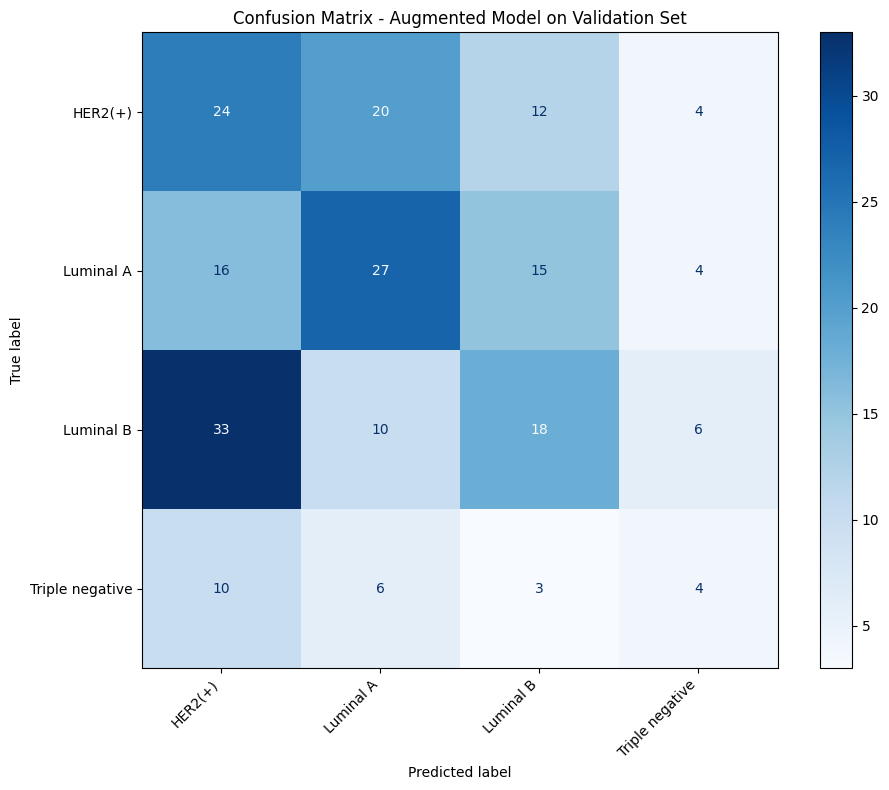

In [8]:
if(augmentation):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    # Cell 7 - Confusion Matrix on Validation Set

    import matplotlib.pyplot as plt

    # Get predictions on validation set
    aug_model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = aug_model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title('Confusion Matrix - Augmented Model on Validation Set')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [9]:
if(augmentation):

    test_loader, test_files = create_test_loader(cfg, val_t)
    run_inference_and_save(cfg, aug_model, test_loader, idx_to_label, device, output_csv="submission_augmented.csv")

Number of test images: 954
First 5 test files: ['img_0000.png', 'img_0001.png', 'img_0002.png', 'img_0003.png', 'img_0004.png']
Saved submission to: c:\Users\danie\ANN\out\submission_augmented.csv
Saved submission to: c:\Users\danie\ANN\out\submission_augmented.csv
